<a href="https://colab.research.google.com/github/yang-song/score_sde_pytorch/blob/main/Score_SDE_demo_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preparation

1. `git clone https://github.com/yang-song/score_sde_pytorch.git`

2. Install [required packages](https://github.com/yang-song/score_sde_pytorch/blob/main/requirements.txt)

3. `cd` into folder `score_sde_pytorch`, launch a local jupyter server and connect to colab following [these instructions](https://research.google.com/colaboratory/local-runtimes.html)

4. Download pre-trained [checkpoints](https://drive.google.com/drive/folders/1tFmF_uh57O6lx9ggtZT_5LdonVK2cV-e?usp=sharing) and save them in the `exp` folder.

In [1]:
#@title Autoload all modules
%load_ext autoreload
%autoreload 2

from dataclasses import dataclass, field
import matplotlib.pyplot as plt
import io
import csv
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import importlib
import os
import functools
import itertools
import torch
from losses import get_optimizer
from models.ema import ExponentialMovingAverage

import torch.nn as nn
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_gan as tfgan
import tqdm
import io
import likelihood
import controllable_generation
from utils import restore_checkpoint
sns.set(font_scale=2)
sns.set(style="whitegrid")

from configs.subvp import xarray_cncsnpp_continuous
import models
from models import utils as mutils
from models import ncsnv2
from models import ncsnpp
from models import cncsnpp
from models import ddpm as ddpm_model
from models import layerspp
from models import layers
from models import normalization
import sampling
from likelihood import get_likelihood_fn
from sde_lib import VESDE, VPSDE, subVPSDE
from sampling import (ReverseDiffusionPredictor, 
                      LangevinCorrector, 
                      EulerMaruyamaPredictor, 
                      AncestralSamplingPredictor, 
                      NoneCorrector, 
                      NonePredictor,
                      AnnealedLangevinDynamics)
import datasets

import os
import xarray as xr

from ml_downscaling_emulator.utils import cp_model_rotated_pole

# Predictor Corrector sampling


Recommended settings:

 | dataset | SDE | predictor | corrector | snr | n_steps |
|:----:|:----:|:----------:|:--------:|:---:|:----:|
|CIFAR-10 | VE | ReverseDiffusionPredictor | LangevinCorrector | 0.16| 1|
|CIFAR-10 | VP | EulerMaruyamaPredictor | None | - | - |
|CIFAR-10 | subVP| EulerMaruyamaPredictor | None | - | - |
| LSUN/CelebA-HQ/FFHQ 256px | VE | ReverseDiffusionPredictor | LangevinCorrector | 0.075 | 1 |
| FFHQ 1024px | VE | ReverseDiffusionPredictor | LangevinCorrector | 0.15| 1 |

Check `probability_flow` to run PC sampling based on discretizing the probability flow ODE.

## Conditional score models

Lo-res precip to hi-res precip

In [2]:
def load_model(config, sde, ckpt_filename):
    sde = subVPSDE(beta_min=config.model.beta_min, beta_max=config.model.beta_max, N=config.model.num_scales)
    sampling_eps = 1e-3

    random_seed = 0 #@param {"type": "integer"}

    sigmas = mutils.get_sigmas(config)
    scaler = datasets.get_data_scaler(config)
    inverse_scaler = datasets.get_data_inverse_scaler(config)
    score_model = mutils.create_model(config)

    optimizer = get_optimizer(config, score_model.parameters())
    ema = ExponentialMovingAverage(score_model.parameters(),
                                   decay=config.model.ema_rate)
    state = dict(step=0, optimizer=optimizer,
                 model=score_model, ema=ema)

    state = restore_checkpoint(ckpt_filename, state, config.device)
    ema.copy_to(score_model.parameters())

    # Sampling
    sampling_shape = (config.training.batch_size, config.data.num_channels,
                          config.data.image_size, config.data.image_size)
    sampling_fn = sampling.get_sampling_fn(config, sde, sampling_shape, inverse_scaler, sampling_eps)
    
    return score_model, sampling_fn


In [3]:
def generate_samples(sampling_fn, score_model, config, cond_xr, norm_factors, num_samples = 3):
    cond_batch = torch.Tensor(cond_xr['pr'].values/norm_factors["pr"]).unsqueeze(dim=1).to(config.device)
    samples = [sampling_fn(score_model, cond_batch)[0]*norm_factors["target_pr"] for i in range(num_samples)]
    return samples

In [4]:
def generate_predictions(sampling_fn, score_model, config, cond_xr, norm_factors, num_samples = 3):
    samples = generate_samples(sampling_fn, score_model, config, cond_xr, norm_factors, num_samples)
    
    coords = {"time": cond_xr.coords["time"], "grid_longitude": cond_xr.coords["grid_longitude"], "grid_latitude": cond_xr.coords["grid_latitude"]}
    dims=["time", "grid_latitude", "grid_longitude"]
    ds = xr.Dataset(
        data_vars={key: cond_xr.data_vars[key] for key in ["grid_latitude_bnds", "grid_longitude_bnds", "rotated_latitude_longitude"]},
        coords=coords,
        attrs={}
    )
    ds['target_pr'] = cond_xr['target_pr']
    ds['pr'] = cond_xr['pr'].clip(0.01)
    
    for i, sample in enumerate(samples):
        sample = sample.cpu().numpy().clip(0.01)
        
        ds[f'pred_pr{i}'] = xr.DataArray(sample[:,0], dims=dims)
        
    return ds

In [26]:
def show_predictions(ds, cond_xr, index=0):
    num_predictions = len([k for k in ds.data_vars.keys() if k.startswith("pred_pr")])
    vmin = min(ds['pr'].min().values, ds['target_pr'].min().values, *[ds[f'pred_pr{i}'].min().values for i in range(num_predictions)])
    vmax = max(ds['pr'].max().values, ds['target_pr'].max().values, *[ds[f'pred_pr{i}'].max().values for i in range(num_predictions)])
    vmin = 0.01
#     vmin=None
#     vmax=None
    
    num_plots_per_ts = num_predictions+2 # plot each sample and the coarsened input pr and true target pr
    
    for index in range(len(ds.time)):
        
        fig, axes = plt.subplots(1, num_plots_per_ts, figsize=(32,12), subplot_kw={'projection': cp_model_rotated_pole})
        
        ax = axes[0]
        ds.isel(time=index)["target_pr"].plot(ax=ax, cmap='Blues', norm=matplotlib.colors.LogNorm(), vmin=vmin, vmax=vmax, add_colorbar=False)
        ax.set_title("")
        ax.coastlines()
        
        ax = axes[1]
        ds.isel(time=index)["pr"].plot(ax=ax, cmap='Blues', norm=matplotlib.colors.LogNorm(), vmin=vmin, vmax=vmax, add_colorbar=False)
        ax.set_title("")
        ax.coastlines()
        
        for i in range(num_predictions):
            ax = axes[2+i]
            ds.isel(time=index)[f"pred_pr{i}"].plot(ax=ax, cmap='Blues', norm=matplotlib.colors.LogNorm(), vmin=vmin, vmax=vmax, add_colorbar=False)
            ax.set_title("")
            ax.coastlines()
        
        plt.show()


In [6]:
sde = 'subVPSDE'#VESDE' #@param ['VESDE', 'VPSDE', 'subVPSDE'] {"type": "string"}
config = xarray_cncsnpp_continuous.get_config()
batch_size = 8
config.training.batch_size = batch_size
config.eval.batch_size = batch_size

### 2x

In [22]:
workdir = os.path.join(os.getenv("DERIVED_DATA"), "score-sde", "workdirs", "subvpsde", "xarray_cncsnpp_continuous", "2.2km-coarsened-2x_london_pr_random")
checkpoint_id = 8
ckpt_filename = os.path.join(workdir, "checkpoints", f"checkpoint_{checkpoint_id}.pth")
                       
score_model, sampling_fn = load_model(config, sde, ckpt_filename)

# Data
data_dirpath = os.path.join(os.getenv('DERIVED_DATA'), 'nc-datasets', '2.2km-coarsened-2x_london_pr_random')
xr_data_train = xr.load_dataset(os.path.join(data_dirpath, 'train.nc')).isel(grid_longitude=slice(0, 32),grid_latitude=slice(0, 32))
xr_data_eval = xr.load_dataset(os.path.join(data_dirpath, 'val.nc')).isel(grid_longitude=slice(0, 32),grid_latitude=slice(0, 32))

norm_factors = {
    "pr": xr_data_train["pr"].max().values.item(), # 160.27401733,
    "target_pr": xr_data_train["target_pr"].max().values.item() #211.29924011,
}

In [23]:
eval_cond_xr = xr_data_eval.isel(time=slice(0,batch_size))
ds = generate_predictions(sampling_fn, score_model, config, eval_cond_xr, norm_factors)

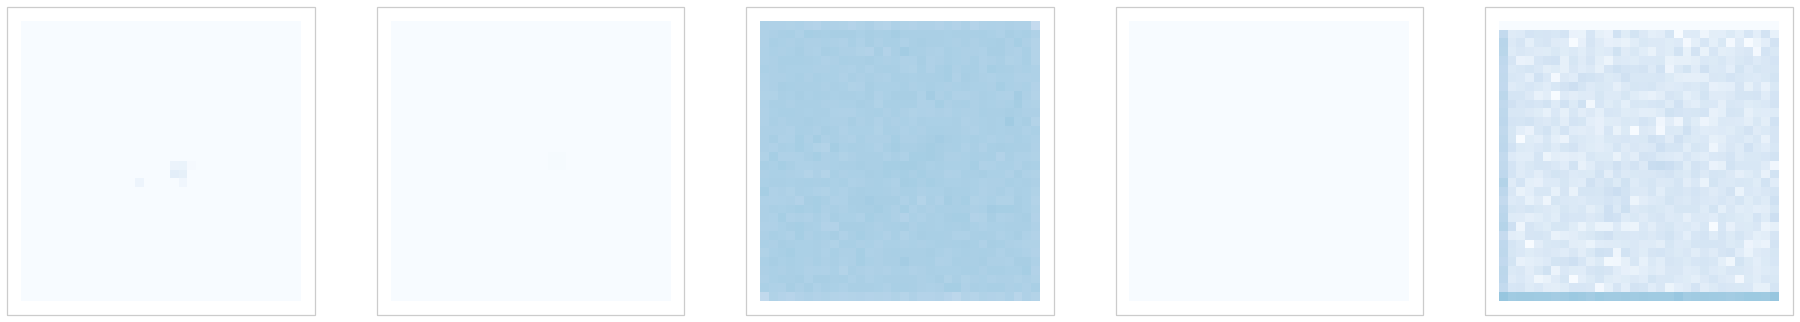

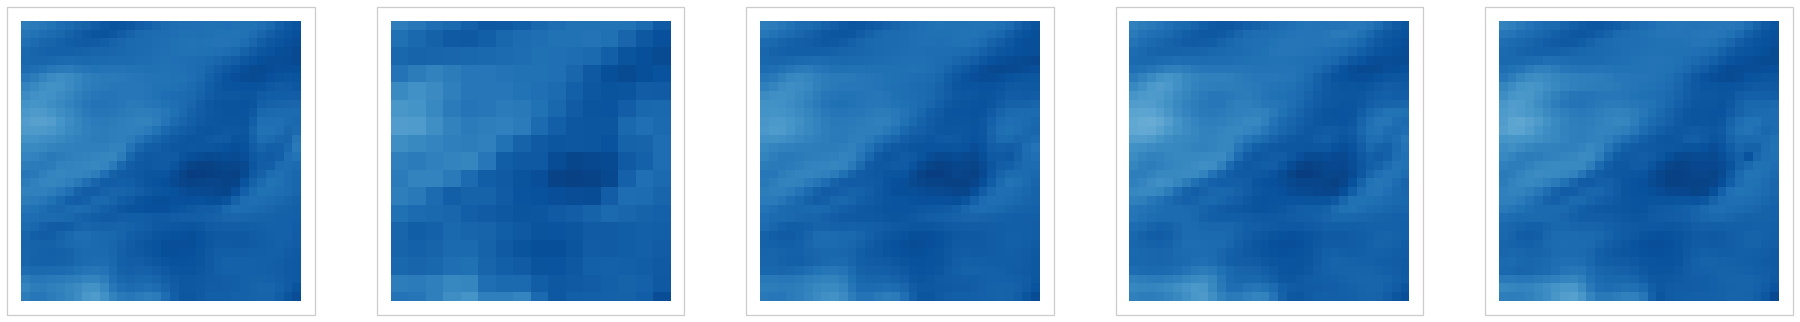

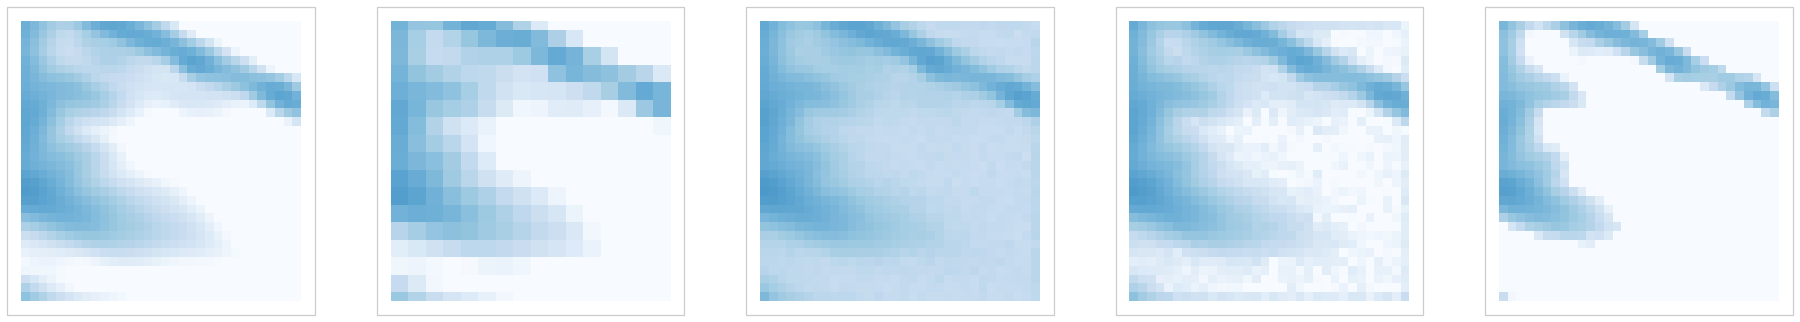

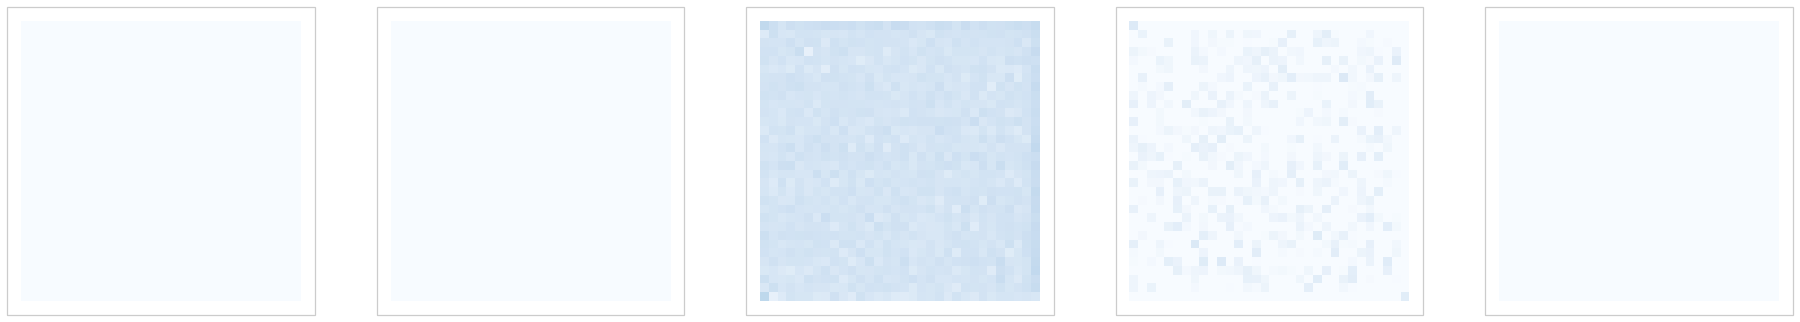

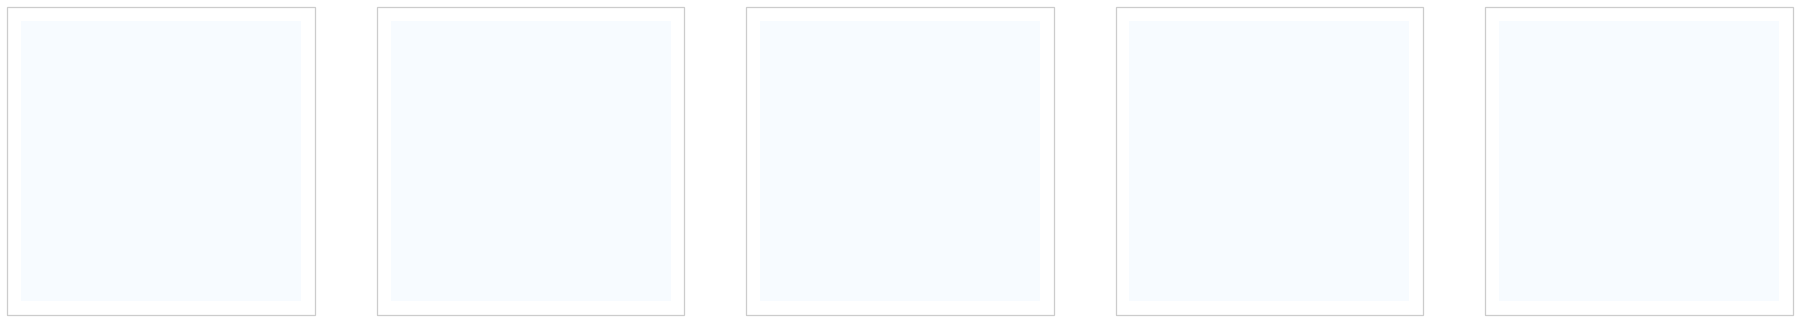

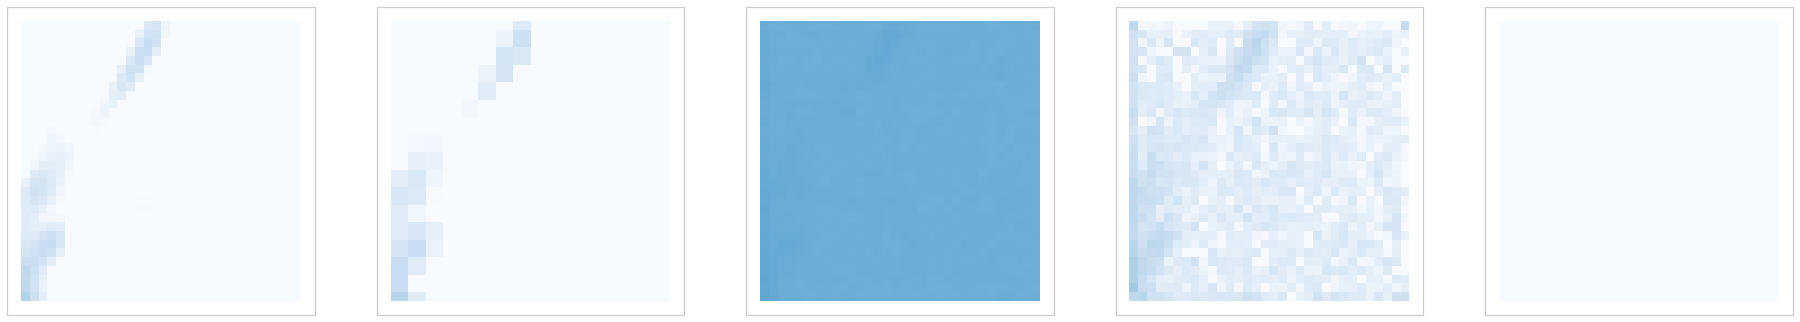

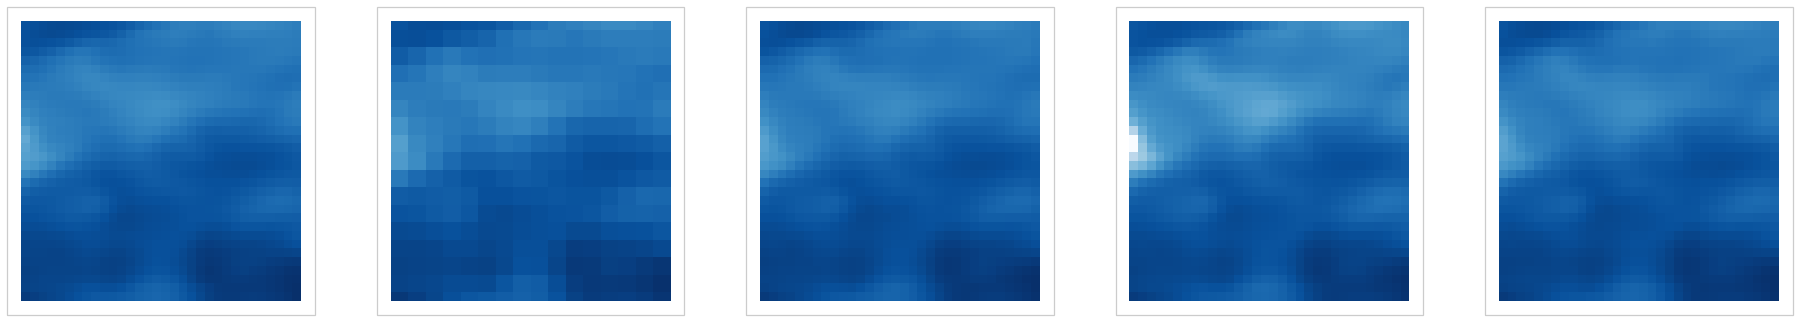

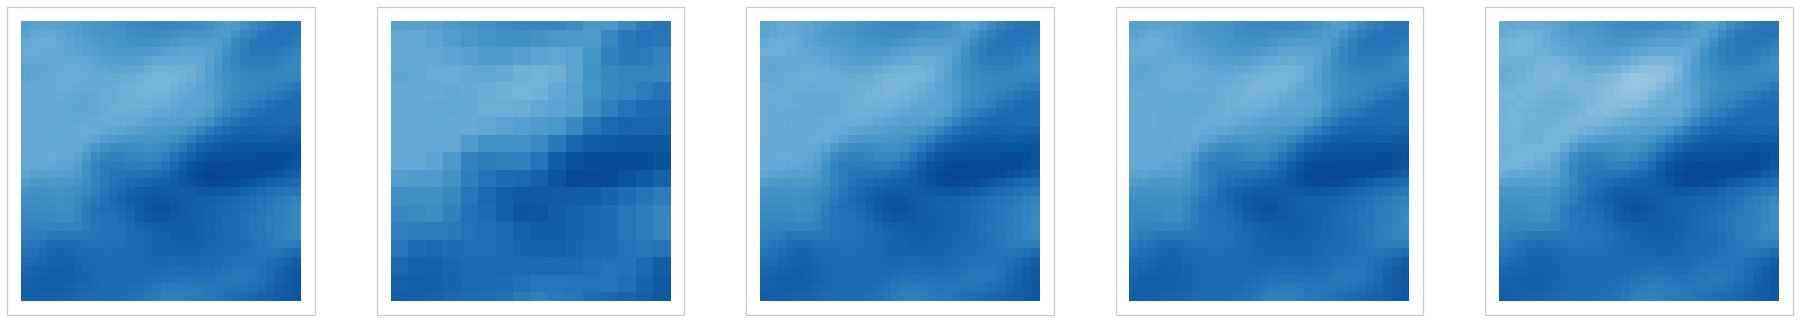

In [27]:
show_predictions(ds, eval_cond_xr)

### 8x

In [11]:
workdir = os.path.join(os.getenv("DERIVED_DATA"), "score-sde", "workdirs", "subvpsde", "xarray_cncsnpp_continuous", "2.2km-coarsened-8x_london_pr_random")
checkpoint_id = 12
ckpt_filename = os.path.join(workdir, "checkpoints", f"checkpoint_{checkpoint_id}.pth")
                       
score_model, sampling_fn = load_model(config, sde, ckpt_filename)

# Data
data_dirpath = os.path.join(os.getenv('DERIVED_DATA'), 'nc-datasets', '2.2km-coarsened-8x_london_pr_random')
xr_data_train = xr.load_dataset(os.path.join(data_dirpath, 'train.nc')).isel(grid_longitude=slice(0, 32),grid_latitude=slice(0, 32))
xr_data_eval = xr.load_dataset(os.path.join(data_dirpath, 'val.nc')).isel(grid_longitude=slice(0, 32),grid_latitude=slice(0, 32))

norm_factors = {
    "pr": xr_data_train["pr"].max().values.item(), # 160.27401733,
    "target_pr": xr_data_train["target_pr"].max().values.item() #211.29924011,
}

In [12]:
eval_cond_xr = xr_data_eval.isel(time=slice(0,batch_size))
ds = generate_predictions(sampling_fn, score_model, config, eval_cond_xr, norm_factors)

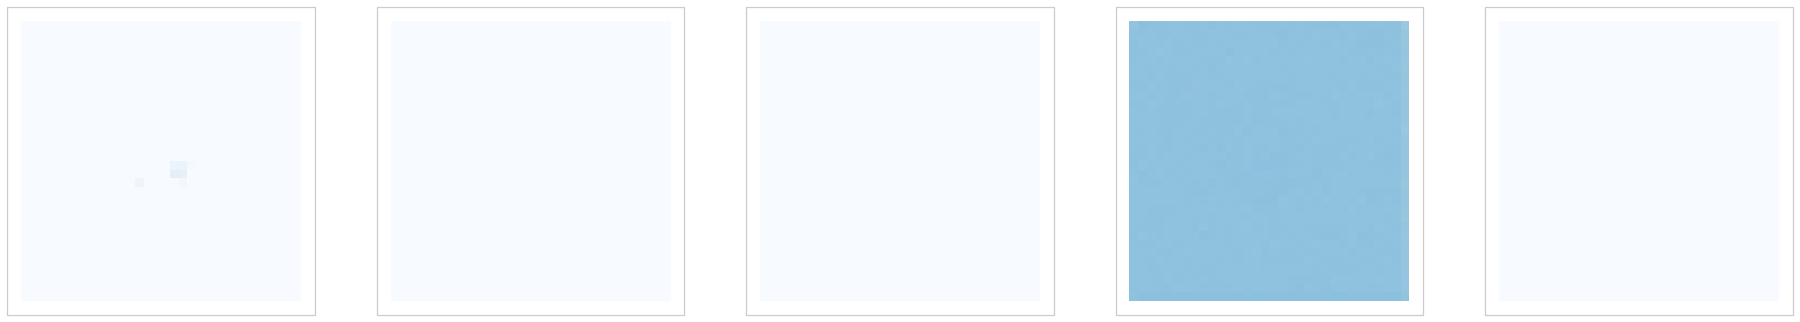

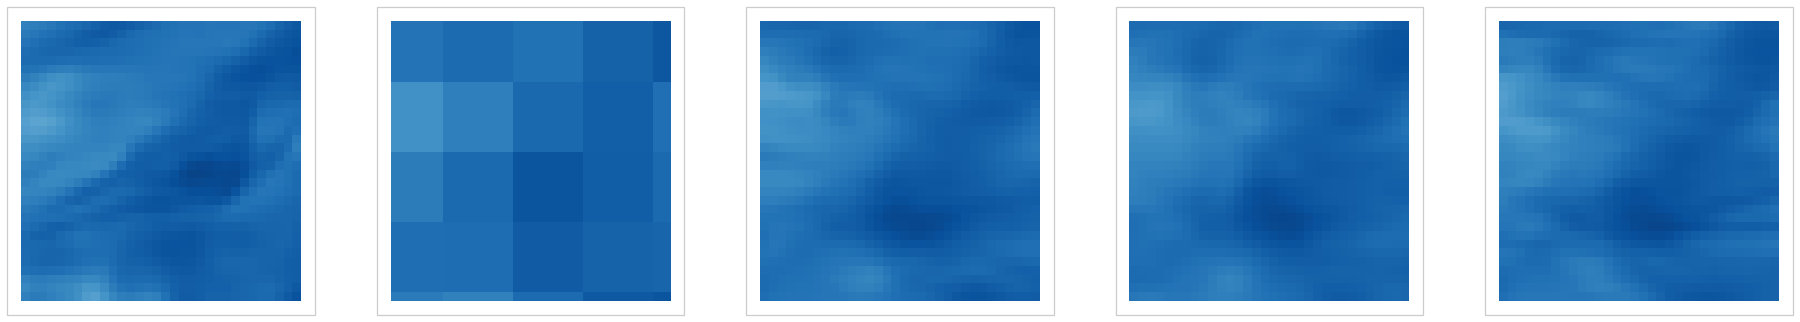

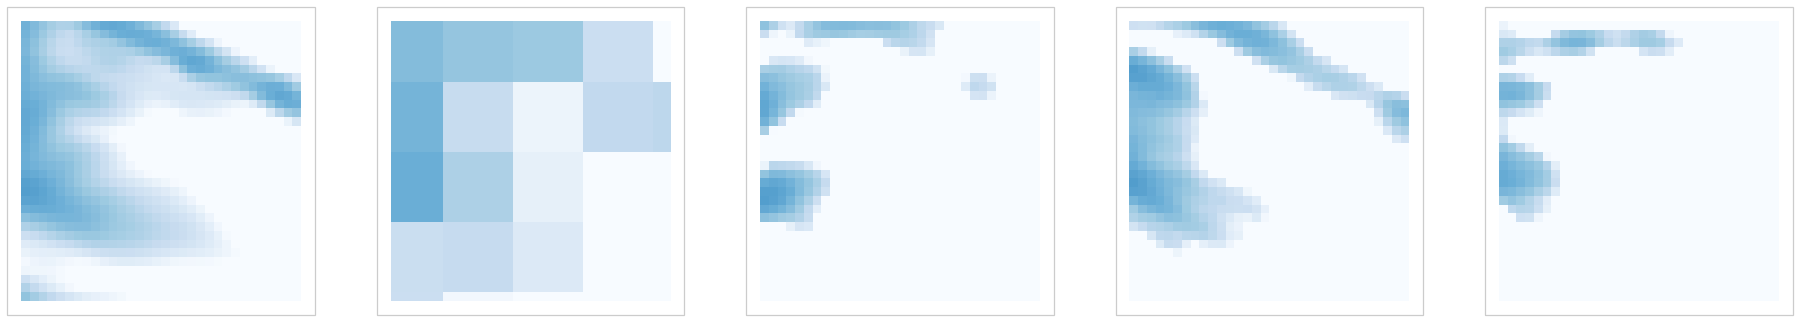

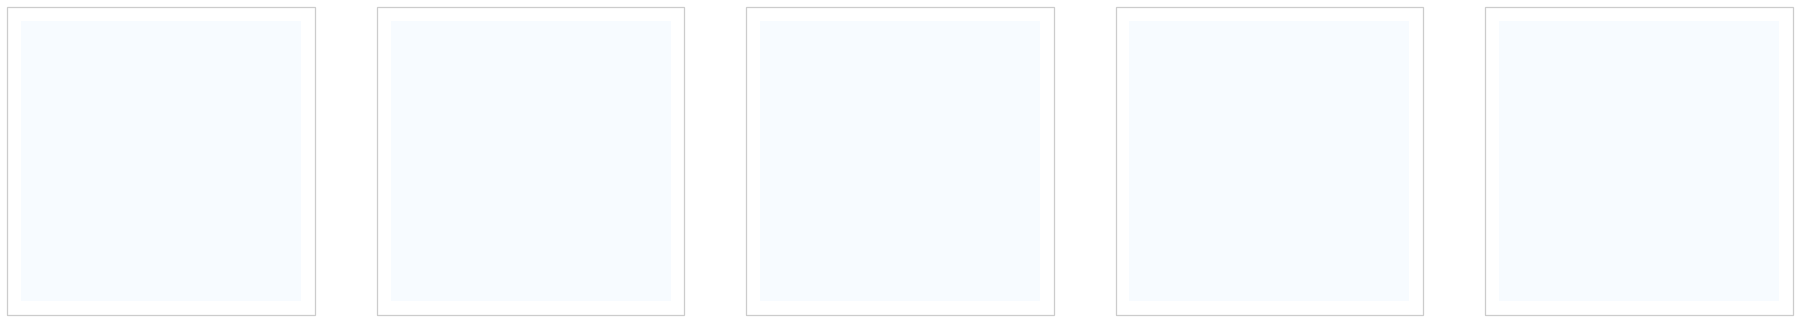

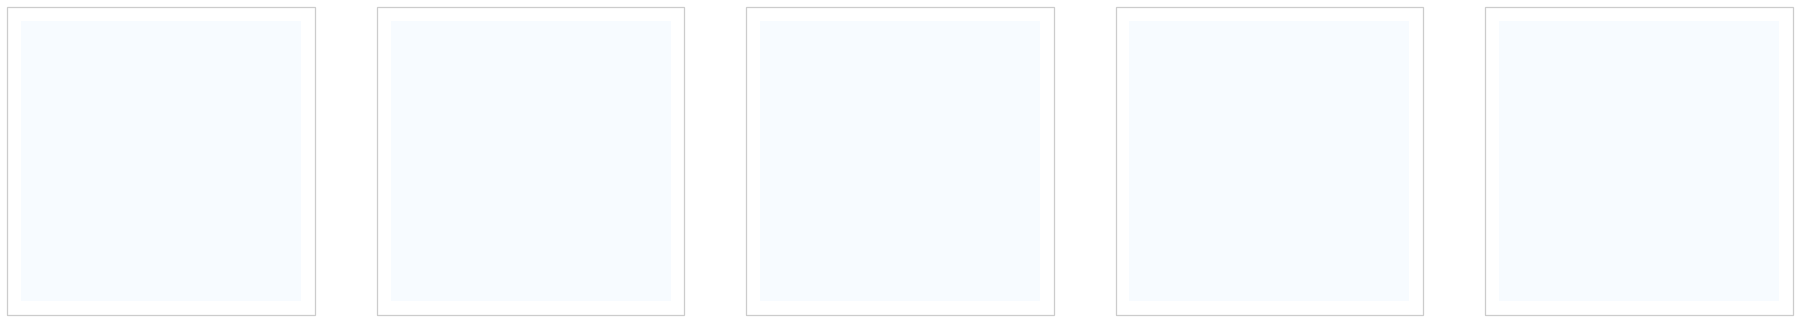

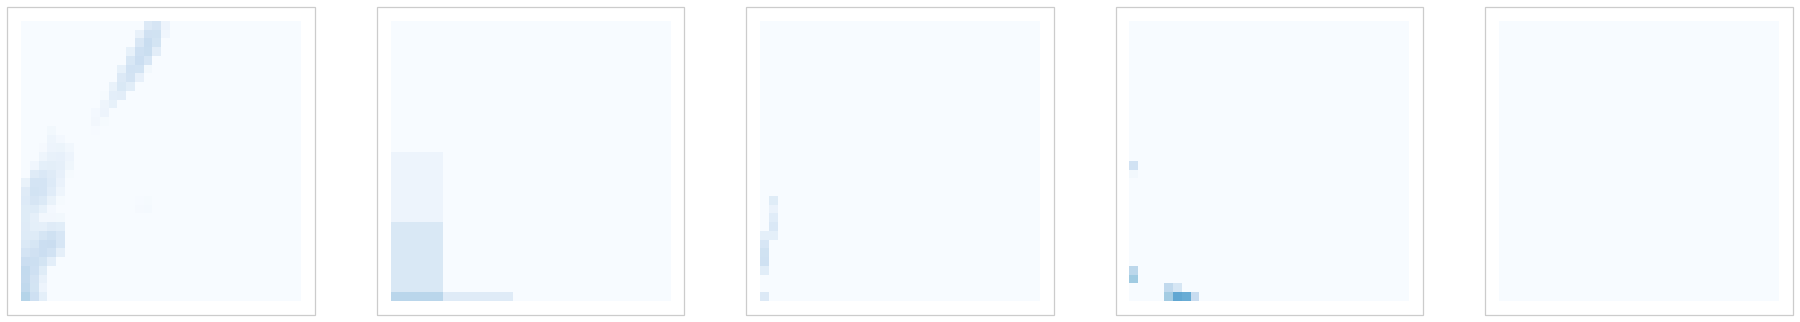

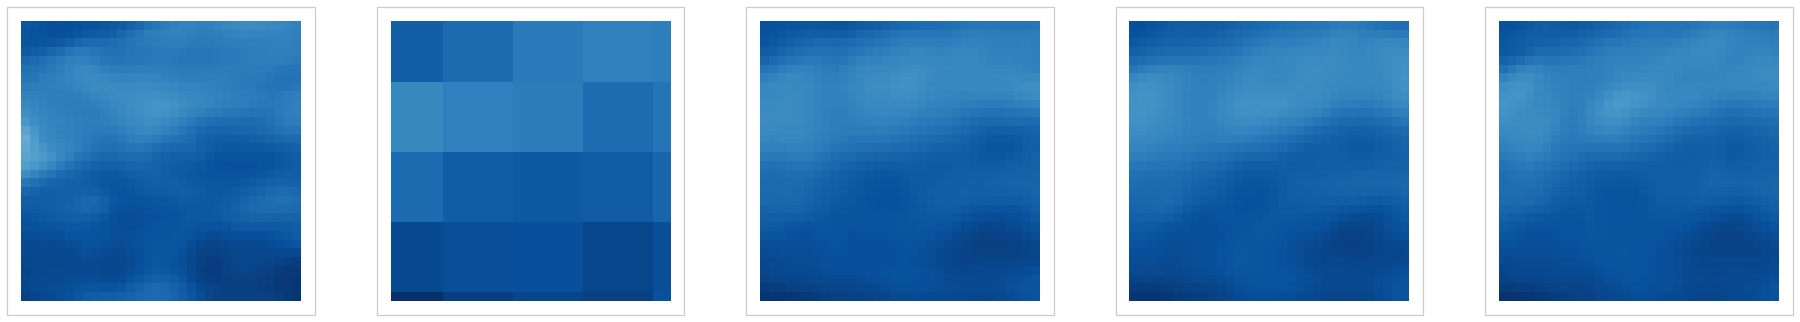

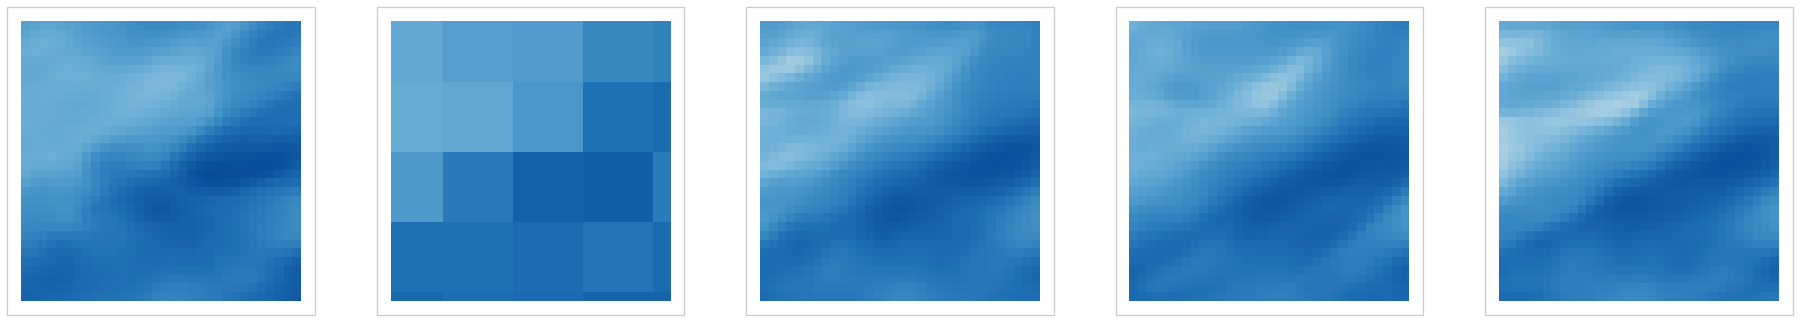

In [13]:
show_predictions(ds, eval_cond_xr)

### 16x

In [14]:
workdir = os.path.join(os.getenv("DERIVED_DATA"), "score-sde", "workdirs", "subvpsde", "xarray_cncsnpp_continuous", "2.2km-coarsened-16x_london_pr_random")
checkpoint_id = 16
ckpt_filename = os.path.join(workdir, "checkpoints", f"checkpoint_{checkpoint_id}.pth")
                       
score_model, sampling_fn = load_model(config, sde, ckpt_filename)

# Data
data_dirpath = os.path.join(os.getenv('DERIVED_DATA'), 'nc-datasets', '2.2km-coarsened-16x_london_pr_random')
xr_data_train = xr.load_dataset(os.path.join(data_dirpath, 'train.nc')).isel(grid_longitude=slice(0, 32),grid_latitude=slice(0, 32))
xr_data_eval = xr.load_dataset(os.path.join(data_dirpath, 'val.nc')).isel(grid_longitude=slice(0, 32),grid_latitude=slice(0, 32))

norm_factors = {
    "pr": xr_data_train["pr"].max().values.item(), # 160.27401733,
    "target_pr": xr_data_train["target_pr"].max().values.item() #211.29924011,
}

In [15]:
eval_cond_xr = xr_data_eval.isel(time=slice(0,batch_size))
ds = generate_predictions(sampling_fn, score_model, config, eval_cond_xr, norm_factors)

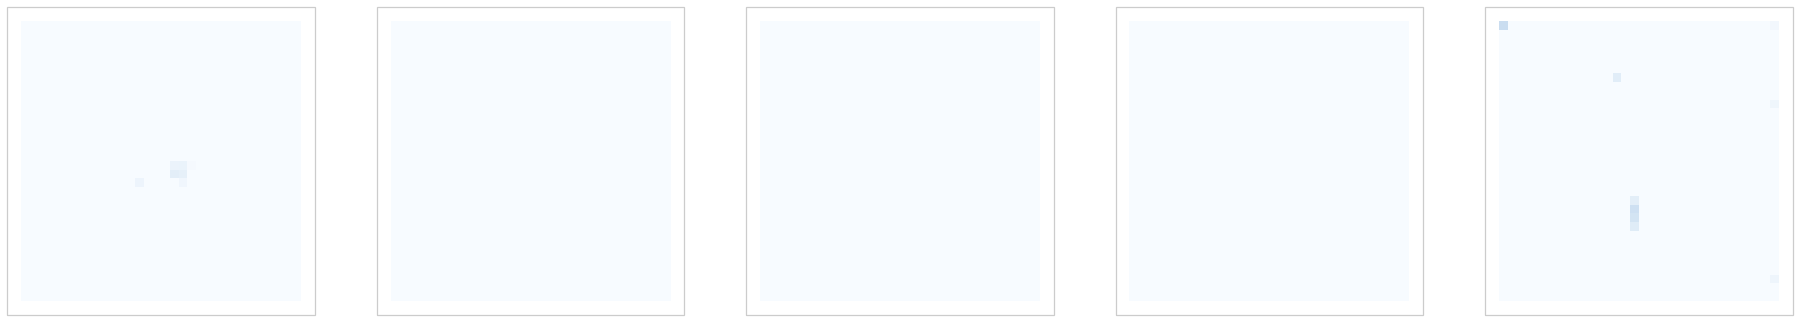

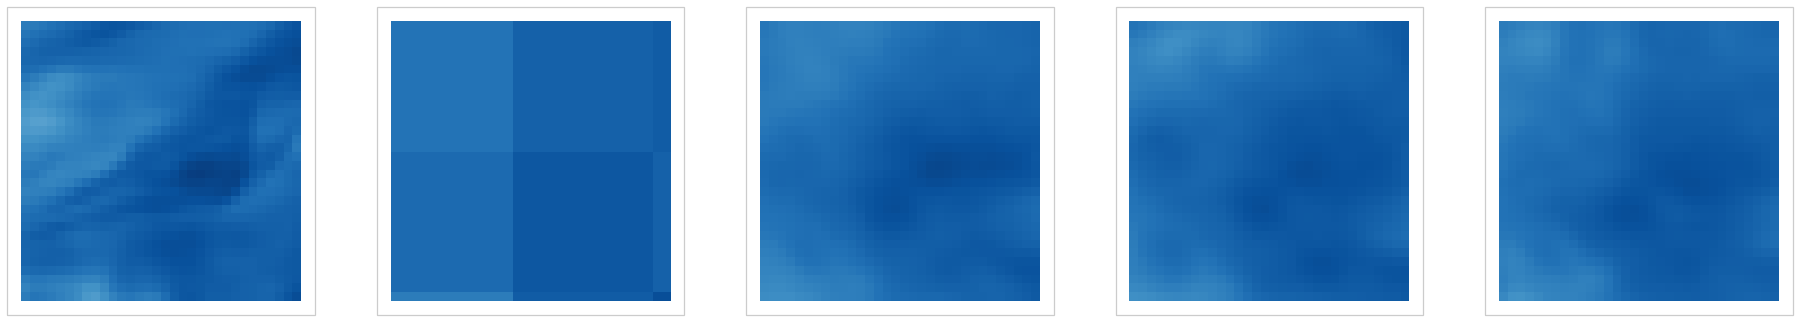

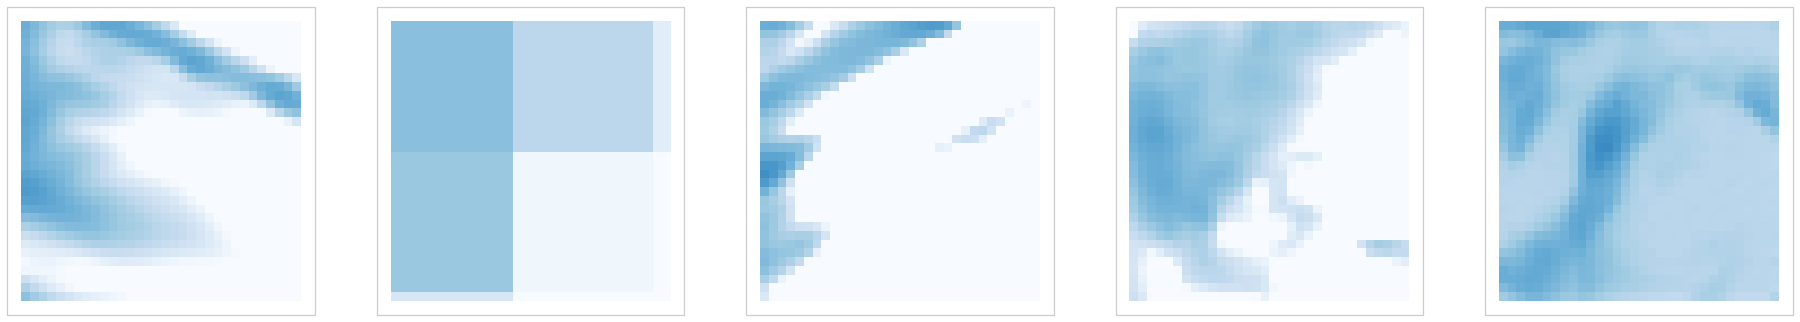

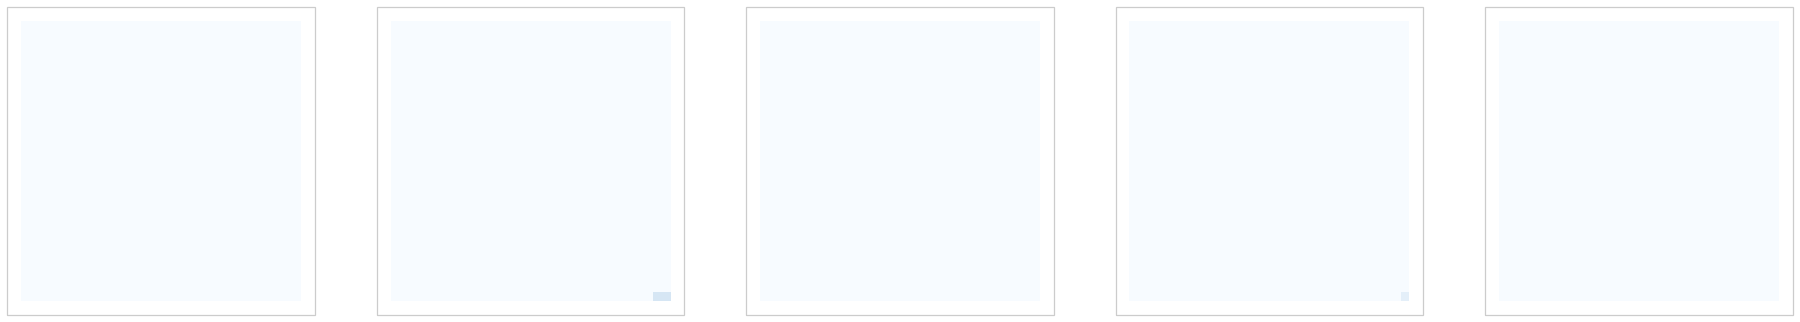

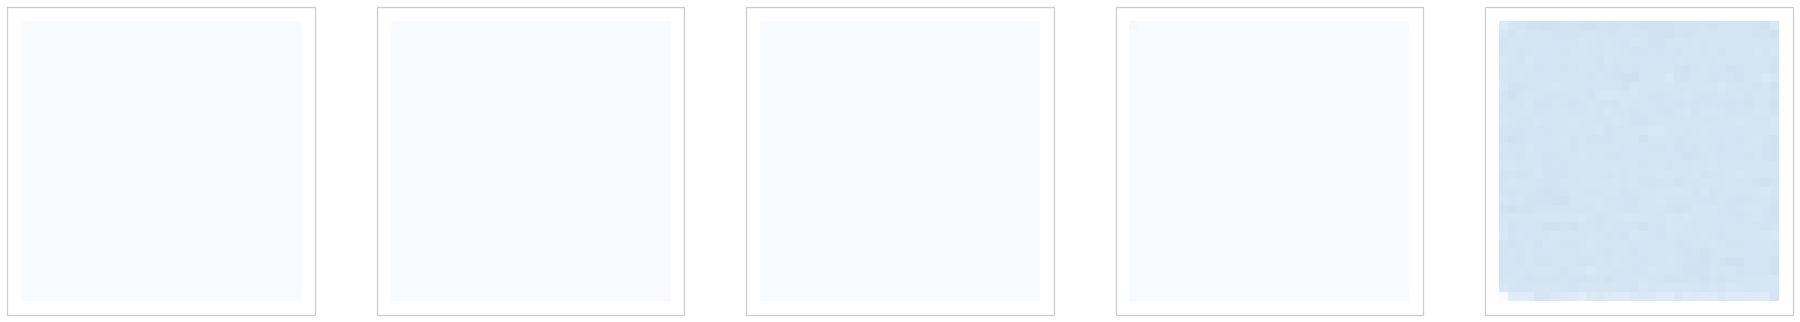

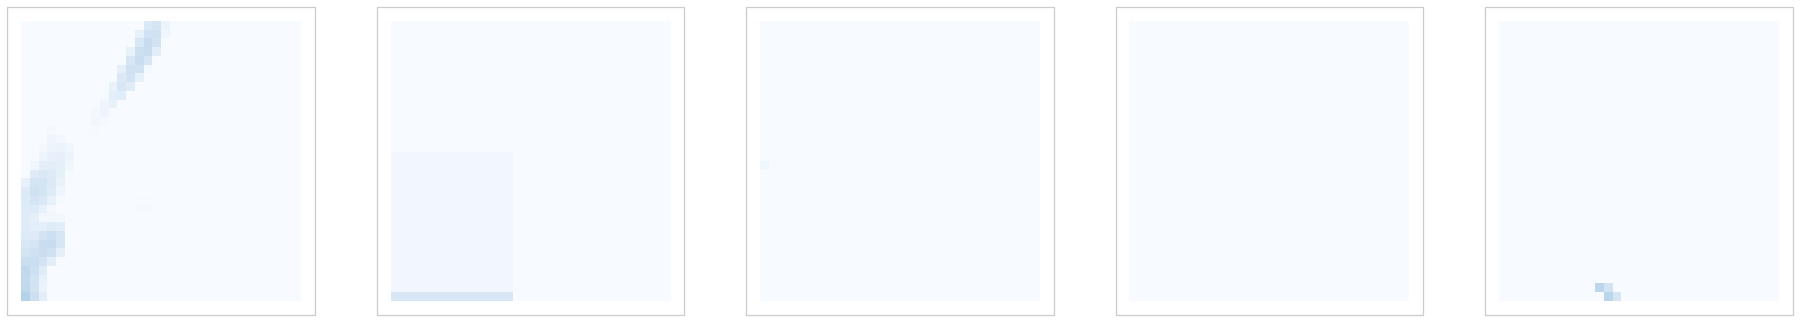

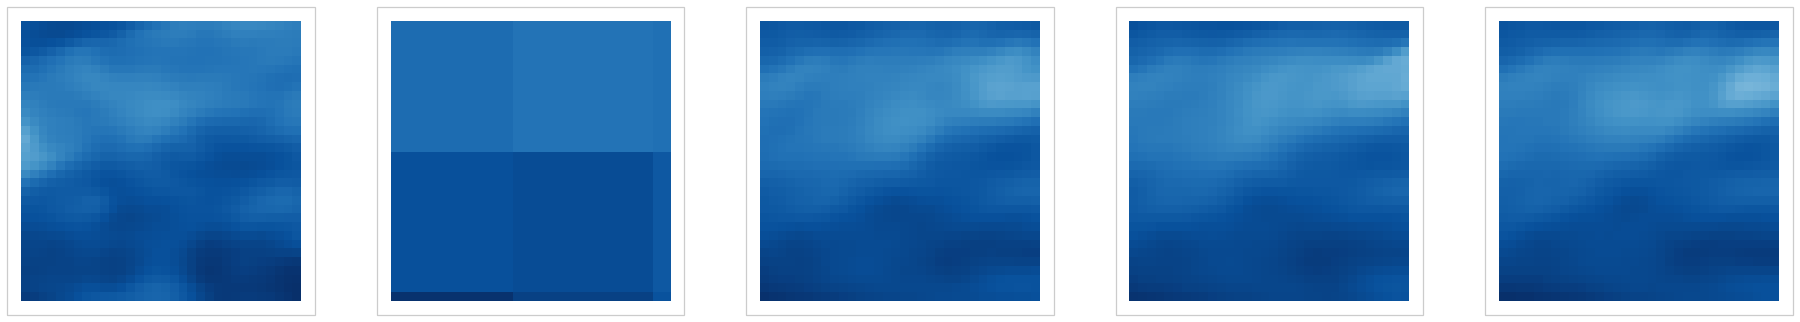

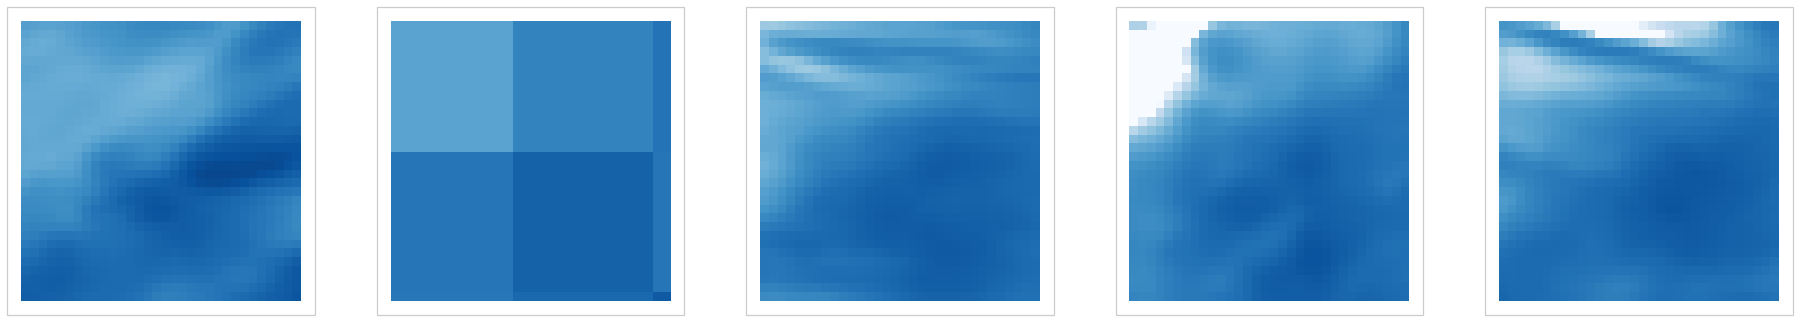

In [16]:
show_predictions(ds, eval_cond_xr)